# Reservoir computing clásico y cuántico en señal compleja.

## Carga de librerías.

In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from scipy.signal import hilbert, butter, filtfilt
from sklearn.cluster import KMeans
import pandas as pd
import random

## Generación de la señal compleja.

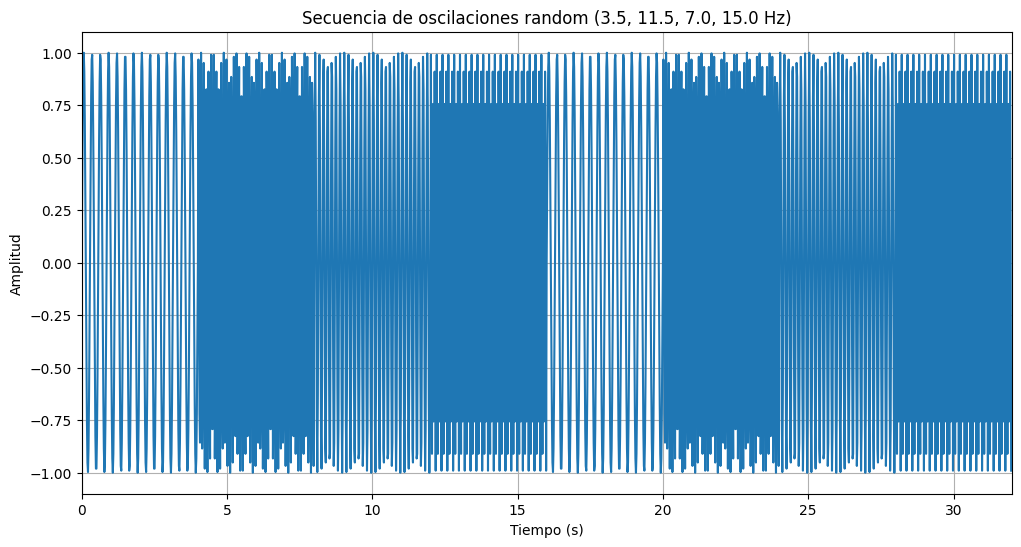

In [2]:
# Parámetros  
fs = 55            # Frecuencia de muestreo en Hz  
t_total = 32        # Duración total en segundos  
frecuencias = [3.5, 11.5, 7.0, 15.0]  # Cuatro frecuencias en Hz  
duracion_segmento = 4  # Duración de cada segmento en segundos  
num_repeticiones = 2 # 3 repeticiones = 12 segundos 

# Inicializamos la secuencia final como una lista  
secuencia2 = []  
amplitud = 1  

# Bucle externo para repetir el ciclo completo  
for i in range(num_repeticiones):  
    # Bucle interno para iterar sobre cada frecuencia en el ciclo  
    for frecuencia_idx in range(len(frecuencias)):  
        # Calcular el tiempo para el segmento actual  
        tiempo_segmento = np.arange(0, duracion_segmento, 1/fs)  
        
        # Calcular la frecuencia basada en el índice del segmento  
        frecuencia_actual = frecuencias[frecuencia_idx]  

        # Generar la oscilación según la frecuencia correspondiente  
        oscilacion = amplitud * np.sin(2 * np.pi * frecuencia_actual * tiempo_segmento)  

        secuencia2.extend(oscilacion)  # Añadir el segmento a la secuencia  

# Convertir la secuencia a un arreglo numpy para facilitar su manejo  
secuencia2 = np.array(secuencia2) 

# Crear el tiempo correspondiente a la secuencia  
t2 = np.arange(0, len(secuencia2)/fs , 1/fs)

# Graficar la señal  
plt.figure(figsize=(12, 6))  
plt.plot(t2, secuencia2)  
plt.title('Secuencia de oscilaciones random (3.5, 11.5, 7.0, 15.0 Hz)')  
plt.xlabel('Tiempo (s)')  
plt.ylabel('Amplitud')  
plt.xlim(0, t_total)  
plt.grid()  
plt.show()

## Implementación clásica.

In [57]:
# Función para aplicar un filtro pasa-banda
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [ ]:
# Parámetros
num_input_channels = 1      # Dimensionalidad de entrada (1 canal)
num_reservoir_neurons = 5   # Número de neuronas en el reservorio
num_readout_neurons = 1      # Número de neuronas de salida

num_training_samples = t2.shape[0] # Número de muestras de entrenamiento

# Generar pesos de entrada al reservorio
input2res = np.random.randn(num_reservoir_neurons, num_input_channels)

# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)

# Normalizar las columnas de los pesos recurrentes
res2res = res2res / np.linalg.norm(res2res, axis=0)

# Sesgo del reservorio
input_bias = np.random.rand(num_reservoir_neurons, 1)

sec2 = secuencia2.reshape(1, len(secuencia2))

# Estados iniciales del reservorio
#reservoir_states = np.zeros((num_reservoir_neurons, num_training_samples + 1))
reservoir_states = np.random.randn(num_reservoir_neurons,num_training_samples + 1);

# Dinámicas del reservorio
for i in range(num_training_samples):
    reservoir_states[:, i + 1] = np.tanh(
        (0.05 * input2res @ sec2[:, i]) +
        (0.95 * res2res @ reservoir_states[:, i]) +
        input_bias.flatten()
    )

# Extracción de la envolvente superior usando Hilbert transform
RS2 = reservoir_states - np.mean(reservoir_states,axis=1, keepdims=True)
print(RS2.shape)
# Parámetros
fs = 55  # Frecuencia de muestreo
lowcut = 3.5  # Frecuencia baja del filtro
highcut = 15  # Frecuencia alta del filtro

# Aplicar filtro antes de Hilbert
x_filtered = bandpass_filter(RS2, lowcut, highcut, fs)

analytic_signal = hilbert(x_filtered, axis = 1)
amplitude_envelope2 = np.abs(analytic_signal)

print(analytic_signal.shape)
print(amplitude_envelope2.shape)

(5, 1761)
(5, 1761)
(5, 1761)


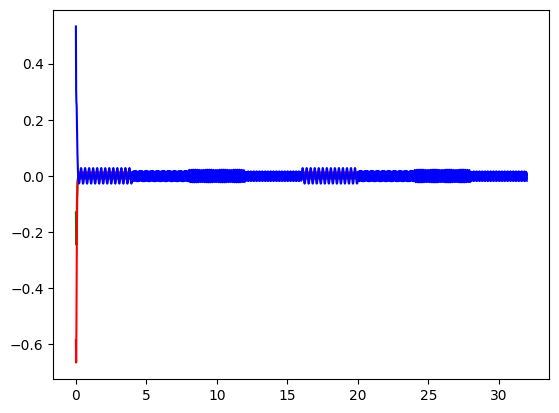

In [4]:
# estados del reservoir después de aplicarse el filtro pasa-banda.
plt.plot(t2, RS2[0, 1:], color = 'green')
plt.plot(t2, RS2[1, 1:], color = 'red')
plt.plot(t2, RS2[2, 1:], color = 'blue')
plt.show()

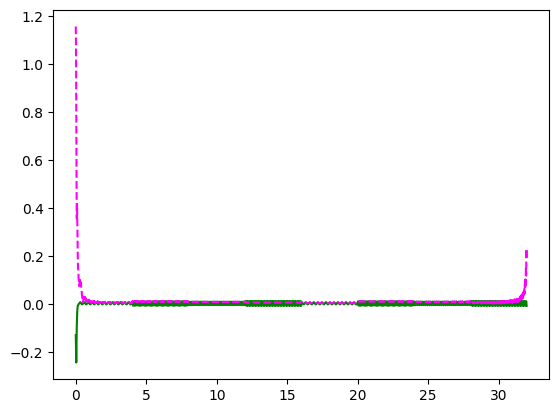

In [5]:
plt.plot(t2, RS2[0, 1:], color = 'green')
plt.plot(t2, amplitude_envelope2[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

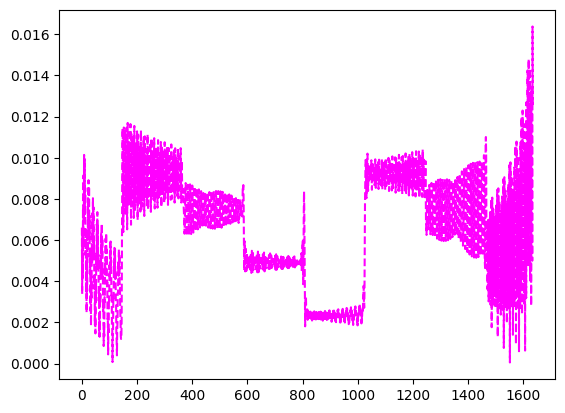

In [6]:
# Eliminamos los primeros puntos para estabilizar el reservorio
stable_start = min(75, amplitude_envelope2.shape[1])
input_sequence2 = amplitude_envelope2[:, stable_start:-50]
plt.plot(input_sequence2[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [7]:
# Agrupamiento con algoritmo GMM(Gaussian Mixture Model).

from sklearn.mixture import GaussianMixture

def clustering_gmm(input_sequence, n_components=4):  
    """  
    Función para realizar agrupamiento usando GMM.  

    Args:  
    - input_sequence: Array de entrada procesado para el agrupamiento.  
    - num_clusters: Número de estados cerebrales. Default es 4.  

    Returns:  
    - labels: Etiquetas de los clústeres asignados a cada muestra de entrada. 
    """
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    cluster_labels = gmm.fit_predict(input_sequence.T)
    return cluster_labels

idx_gmm = clustering_gmm(input_sequence2)

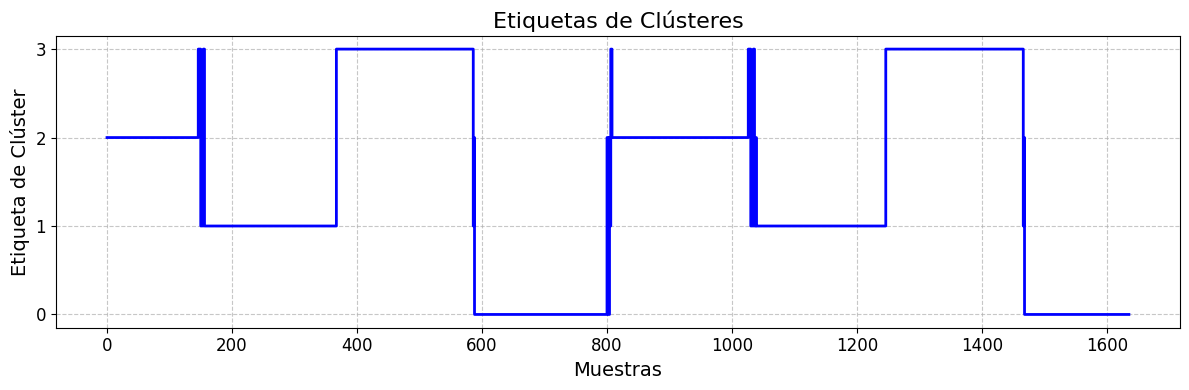

In [8]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence2.shape[1]), idx_gmm, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(4))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

Graficamos la señal junto con el clustering realizado.

In [9]:
stable_start = min(75, len(secuencia2))
secuencia22 = secuencia2[stable_start:-50]
secuencia22.shape

(1635,)

In [10]:
stable_start = min(75, len(t2))
t22 = t2[stable_start:-50]
t22.shape

(1635,)

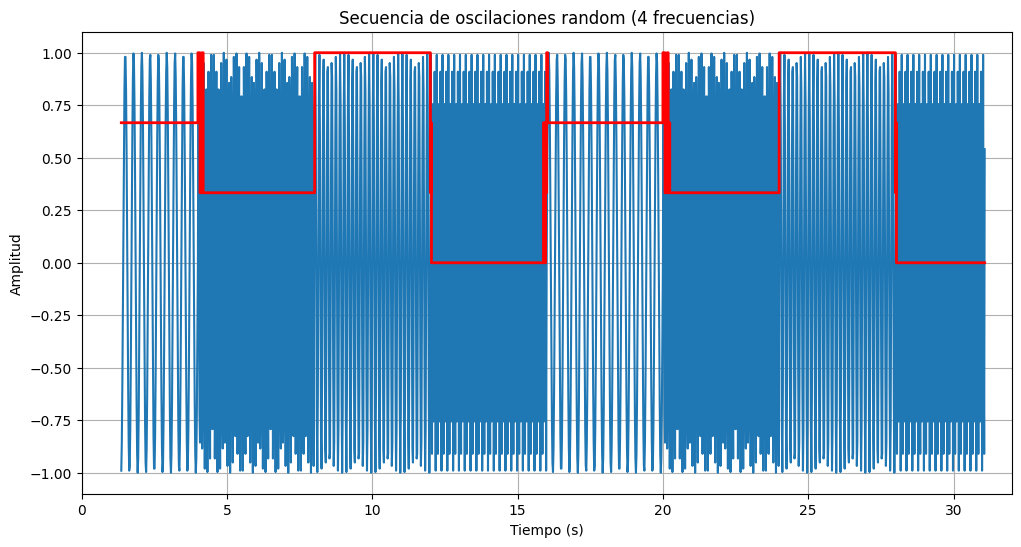

In [11]:
plt.figure(figsize=(12, 6))  
plt.plot(t22, secuencia22)
plt.step(t22, idx_gmm[1:]/3, where='post', color='red', linewidth=2) 
plt.title('Secuencia de oscilaciones random (4 frecuencias)')  
plt.xlabel('Tiempo (s)')  
plt.ylabel('Amplitud')  
plt.xlim(0, t_total)  
plt.grid()  
plt.show()

## Implementación cuántica.

In [48]:
# Número de qubits (tamaño del reservoir cuántico)
num_qubits = 3
# Profundidad del reservoir.
num_layers = 1  

# Creamos un dispositivo cuántico
dev3 = qml.device("default.qubit", wires=num_qubits)

In [49]:
# Definir el Quantum Reservoir  
def quantum_reservoir(reservoir_weights, connectivity):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""    
    for i in range(num_qubits):
         for j in range(num_qubits):
            # Rotación aleatoria en cada qubit  
            qml.RX(reservoir_weights[i,j], wires= i)
            
    # Aplicar entrelazamiento entre los qubits seleccionados.(conectividad limitada)
    if connectivity == 'ring':
        for j in range(num_qubits - 1):
            qml.CNOT(wires=[j, j+1])  # Apply entanglement between adjacent qubits
                     
                
    if connectivity == 'star':
    # Entangling the first qubit (central node) with all other qubits
        central_qubit = 0  # We use qubit 0 as the central node
        for j in range(1, num_qubits):
             qml.CNOT(wires=[central_qubit, j])
 
    if connectivity == 'random':
            # Crear pares de qubits aleatorios
              qubit_pairs = [(j, k) for j in range(num_qubits) for k in range(j + 1, num_qubits)]
              random.shuffle(qubit_pairs)
            # Entrelazar aleatoriamente
              for j, k in qubit_pairs[:num_qubits // 2]:
                  qml.CNOT(wires=[j, k])
 
    elif connectivity == 'full':
            # Full connectivity: entangle all pairs of qubits
              for j in range(num_qubits):
                 for k in range(j + 1, num_qubits):  # Loop over all pairs of qubits
                    qml.CNOT(wires=[j, k])  # Apply entanglement between qubit j and k

In [50]:
# Define Quantum Node
@qml.qnode(dev3)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights, connectivity):
    """Quantum Echo State Network (QESN)"""
    # Encode input and previous output into qubits
    for i in range(num_qubits):
        qml.RX(.05*weights_in[i] * input_data + .95*weights_rc[i] * prev_output[i], wires=i)
    
    # Evolve through the quantum reservoir
    quantum_reservoir(reservoir_weights, connectivity=connectivity)
    
    # Devolvemos un vector de probabilidades de los estados.
    return qml.probs(wires=range(num_qubits))

In [39]:
# Initialize parameters
weights_in = np.random.uniform(-np.pi, np.pi, num_qubits)
weights_rc = np.random.uniform(-np.pi, np.pi, num_qubits)
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

sec2 = secuencia2.reshape(1, len(secuencia2))
input_series2 = sec2
time_steps = input_series2.shape[1]

# Run QESN
outputs = []
prev_output = np.zeros(num_qubits)  # Initial output

for t0 in range(time_steps):
    q_prob = quantum_echo_state_network(input_series2[0, t0], prev_output, weights_in, weights_rc, reservoir_weights)

    final_output = np.tanh(q_prob) # aplicamos una tangente hiperbólica al vector de probabilidades.

    # Almacenamos el resultado en la lista.
    outputs.append(final_output)
    prev_output = final_output  # Recurrent connection
    print(f"Step {t0}: {final_output}")

# Convertimos outputs a numpy array.
outputs = np.array(outputs)

Step 0: [0.0809361  0.02568873 0.10553122 0.32246179 0.08745421 0.26992935
 0.06703969 0.0212649 ]
Step 1: [0.06506354 0.04320768 0.14697842 0.21948599 0.15930475 0.23751461
 0.07059302 0.0468863 ]
Step 2: [0.0674298  0.06139489 0.18258435 0.20012098 0.17114363 0.18763428
 0.06312893 0.0574771 ]
Step 3: [0.06571655 0.07693993 0.2040119  0.17482287 0.18399912 0.15756051
 0.05912788 0.06923308]
Step 4: [0.06508314 0.08732004 0.21423629 0.16060472 0.18887777 0.14137403
 0.05719554 0.07675733]
Step 5: [0.06466039 0.08973818 0.21359422 0.15485239 0.19170096 0.13877681
 0.0578711  0.08033649]
Step 6: [0.06427566 0.08370392 0.20436556 0.15769192 0.19309257 0.14889976
 0.0606455  0.07898484]
Step 7: [0.06314229 0.07161419 0.18909512 0.16710967 0.19278032 0.17038457
 0.06440057 0.07304018]
Step 8: [0.06101222 0.05752984 0.17039918 0.18051899 0.1892016  0.20038095
 0.06788169 0.06400932]
Step 9: [0.05835444 0.04495212 0.15099983 0.19508875 0.18156295 0.23402927
 0.07037328 0.054222  ]
Step 10: [

(8, 1760)


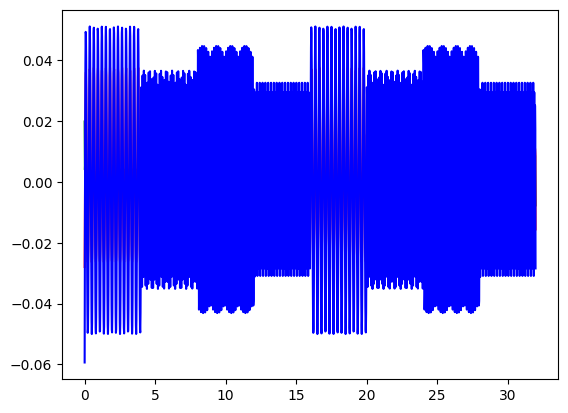

In [40]:
outputs = outputs.T

RS_cuant_2 = outputs - np.mean(outputs,axis=1, keepdims=True)
print(RS_cuant_2.shape)

plt.plot(t2, RS_cuant_2[0, :], color = 'green')
plt.plot(t2, RS_cuant_2[1, :], color = 'red')
plt.plot(t2, RS_cuant_2[2, :], color = 'blue')
plt.show()

In [41]:
# Parámetros
fs = 55  # Frecuencia de muestreo
lowcut = 3.5  # Frecuencia baja del filtro
highcut = 15  # Frecuencia alta del filtro

# Aplicar filtro antes de Hilbert
x_filtered_cuant_2 = bandpass_filter(RS_cuant_2, lowcut, highcut, fs)

In [42]:
analytic_signal = hilbert(x_filtered_cuant_2, axis = 1)
amplitude_envelope_cuant2 = np.abs(analytic_signal)
print(analytic_signal.shape)
print(amplitude_envelope_cuant2.shape)

(8, 1760)
(8, 1760)


(8, 1702)


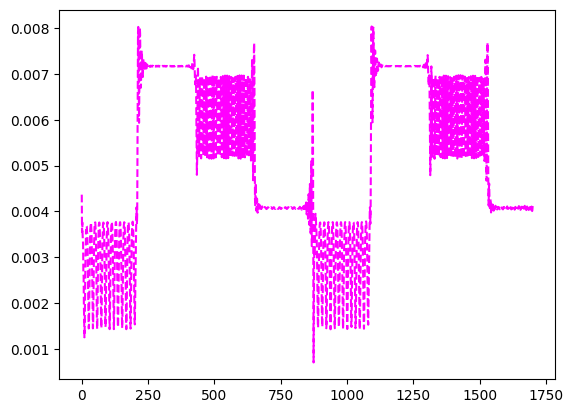

In [43]:
# Eliminar primeros puntos del reservoir.
stable_start = min(90, amplitude_envelope_cuant2.shape[0])
input_sequence_cuantico2 = amplitude_envelope_cuant2[:,stable_start:-50]
print(input_sequence_cuantico2.shape)
plt.plot(input_sequence_cuantico2[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

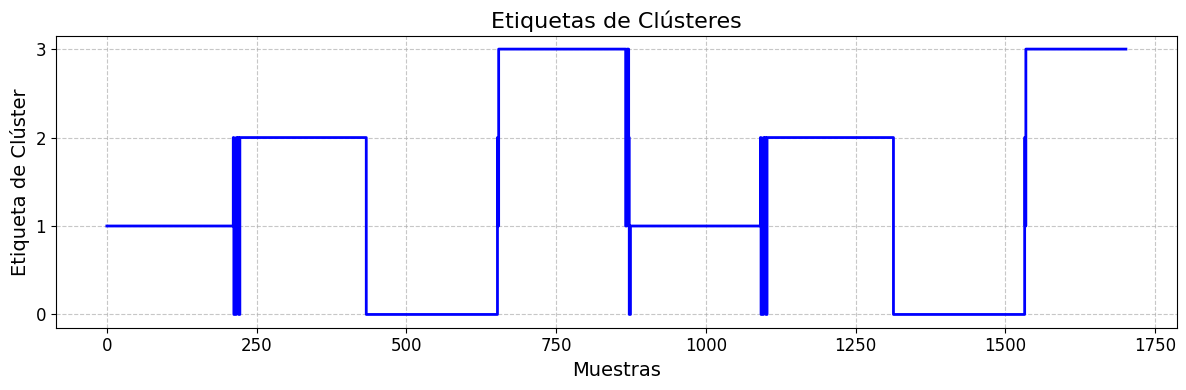

In [44]:
# CLUSTERING GMM.
idx_gmm_cuant = clustering_gmm(input_sequence_cuantico2)

plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence_cuantico2.shape[1]), idx_gmm_cuant, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(4))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

Graficamos la señal junto con el clustering realizado.

In [45]:
stable_start = min(90, amplitude_envelope_cuant2.shape[0])
secuencia23 = secuencia2[stable_start:-50]

In [46]:
stable_start = min(90, amplitude_envelope_cuant2.shape[0])
t23 = t2[stable_start:-50]

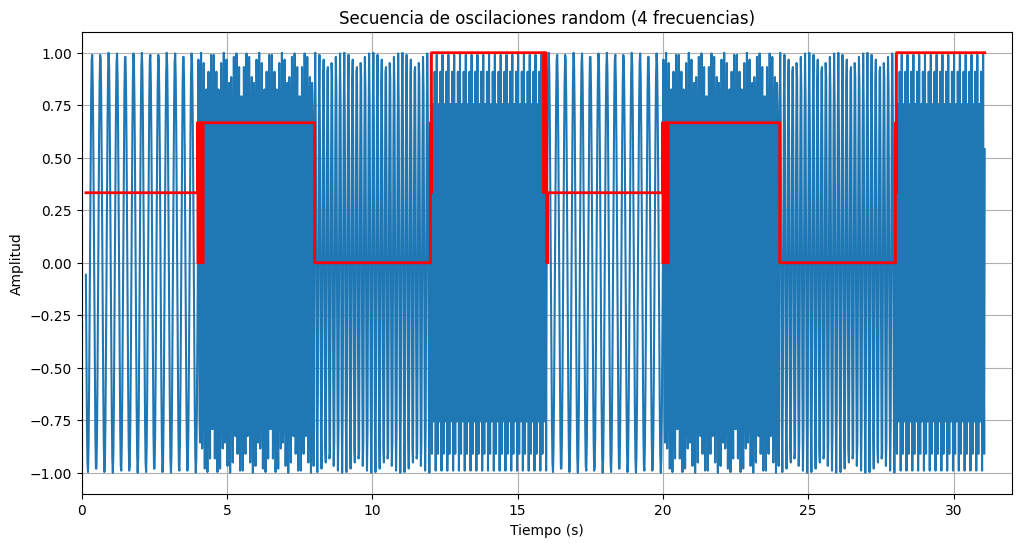

In [47]:
plt.figure(figsize=(12, 6))  
plt.plot(t23, secuencia23)
plt.step(t23, idx_gmm_cuant[:]/3, where='post', color='red', linewidth=2) 
plt.title('Secuencia de oscilaciones random (4 frecuencias)')  
plt.xlabel('Tiempo (s)')  
plt.ylabel('Amplitud')  
plt.xlim(0, t_total)  
plt.grid()  
plt.show()

### Diferentes pruebas de conectividad.

A continuación, vamos a realizar una prueba utilizando los distintos tipos de conectividad entre los qubits para averiguar cuál funciona mejor con la señal que hemos implementado.

In [62]:
# Función que aplica el reservoir computing cuántico.

def reservoir_computing_cuantico(secuencia2, num_qubits = 3, connectivity = 'full'):  
    # Inicialización de pesos 

    weights_in = np.random.uniform(-np.pi, np.pi, num_qubits)
    weights_rc = np.random.uniform(-np.pi, np.pi, num_qubits)
    reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))
    
    sec2 = secuencia2.reshape(1, len(secuencia2))
    input_series = sec2
    time_steps = input_series2.shape[1]
    
    # Array para almacenar las salidas  
    outputs = []  
    prev_output = np.zeros((num_qubits))  
    
    # Loop en el tiempo  
    for t in range(time_steps):  
        q_probs = quantum_echo_state_network(input_series[0, t], prev_output,   
                                             weights_in, weights_rc, reservoir_weights, connectivity = connectivity)  
        final_output = np.tanh(q_probs) # aplicamos una tangente hiperbólica al vector de probabilidades.

        # Almacenamos el resultado en la lista.
        outputs.append(final_output)
        prev_output = final_output  # Recurrent connection

    outputs = np.array(outputs)
    # Transponer y ajustar el array de salida  
    outputs_tr = outputs.T  
    # Restar la media por fila  
    outputs_adj = outputs_tr - np.mean(outputs_tr, axis=1, keepdims=True)
    # filtro pasa-banda
    outputs_adj_filt = bandpass_filter(outputs_adj, lowcut=3.5, highcut=15, fs=55)  
    
    # Aplicar transformada de Hilbert para obtener la señal analítica  
    analytic_signal = hilbert(outputs_adj_filt, axis=1)  
    amplitude_envelope = np.abs(analytic_signal)  
    # Eliminar primeros puntos del reservoir.
    stable_start = min(90, amplitude_envelope.shape[0])
    input_sequence_cuantico = amplitude_envelope[:,stable_start:-50]
    
    return input_sequence_cuantico

In [67]:
# Código que aplica las distintas conectividades entre los qubits.
conectividades = ['full','ring','star','random']
# lista para almacenar el clustering realizado con cada conectividad.
clustering_conect = []

for i in range(len(conectividades)):
    input_sequence = reservoir_computing_cuantico(secuencia2, connectivity=conectividades[i])
    idx_gmm = clustering_gmm(input_sequence)
    clustering_conect.append(idx_gmm)

print(len(clustering_conect))

4


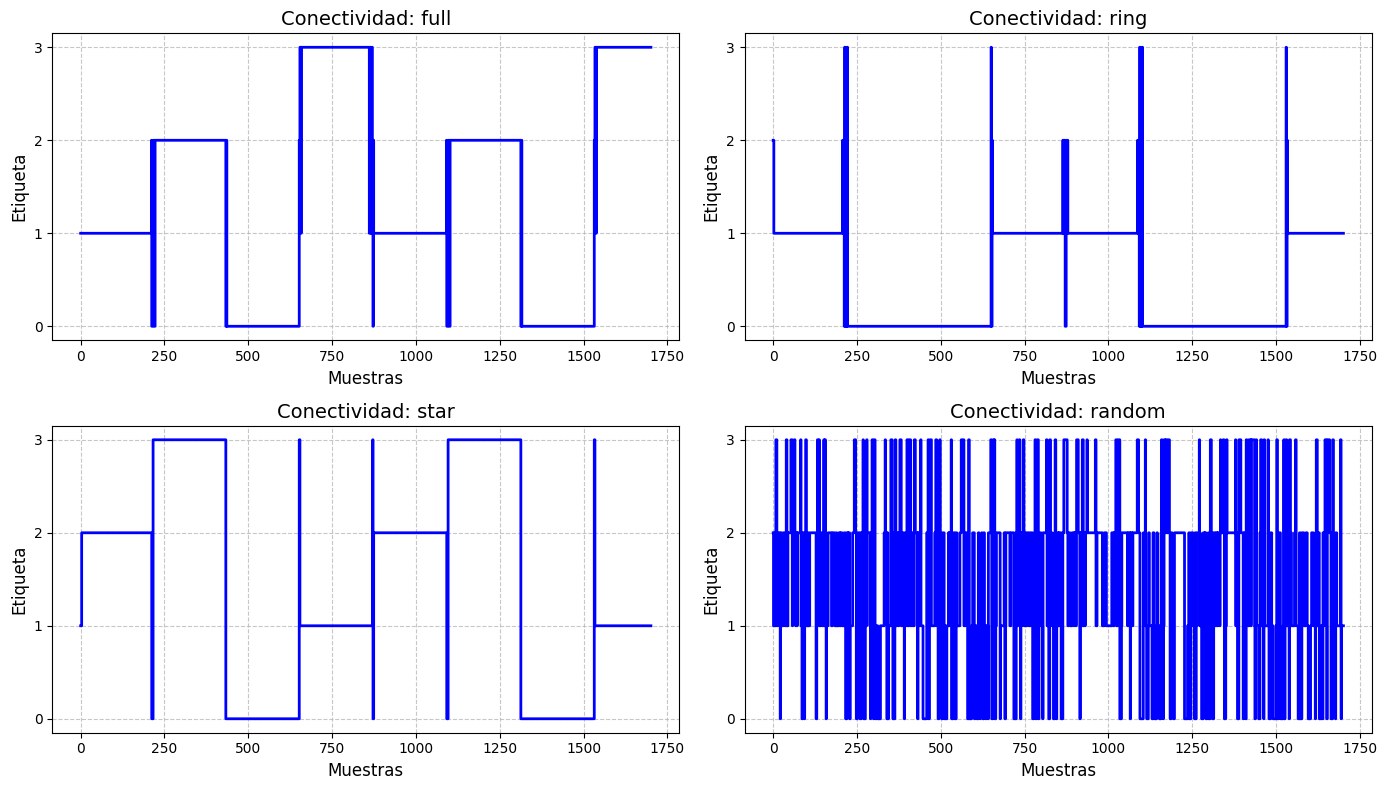

In [68]:
# Representación gráfica de los distintos clustering.
plt.figure(figsize=(14, 8))

for i in range(len(clustering_conect)):
    idx = clustering_conect[i]
    
    plt.subplot(2, 2, i+1)  # 2 filas, 2 columnas de subplots
    plt.step(range(len(idx)), idx, where='post', color='blue', linewidth=2)
    plt.title(f'Conectividad: {conectividades[i]}', fontsize=14)
    plt.xlabel('Muestras', fontsize=12)
    plt.ylabel('Etiqueta', fontsize=12)
    plt.yticks(np.arange(4))  # 4 clusters
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

Observamos que la conectividad 'full' y 'star' funcionan bien ya que ambas detectan los cambios en la frecuencia de la señal, por lo que estas conectividades son las que vamos a considerar a partir de ahora.